In [46]:
from pathlib import Path
from glob import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sage.training.trainer import MRITrainer
from sage.config import load_config
from sage.visualization.vistool import plot_vismap
from sage.visualization.utils import Assembled

from sage.visualization.PyTorchRelevancePropagation.src.lrp import LRPModel

In [2]:
AVG = np.load("./data/average.npy")

cfg = load_config(
    "/workspace/resnet256_augmentation_checkpoints/20211001-1526_resnet/config.yml"
)
cfg.encoder.name = "resnet"
cfg.encoder.config.start_channels = 32
trainer = MRITrainer(cfg)

model = Assembled(trainer.models["encoder"], trainer.models["regressor"])
lrp_model = LRPModel(model=model)

Use cuda:0 as a device.
Output from encoder is 256.
Total Number of parameters: 3634533


In [3]:
RESULT_DIR = "../resnet256_augmentation_checkpoints/"
checkpoint_lists = sorted(glob(f"{RESULT_DIR}/*"))

checkpoint = Path(checkpoint_lists[1])


def load_model_ckpts(path: Path, epoch: int):

    epoch = str(epoch).zfill(3)
    ckpts = dict()
    for model_name in ("encoder", "regressor"):

        ckpt = list(path.glob(f"./{model_name}/ep{epoch}*.pt"))
        assert len(ckpt) == 1
        ckpts[model_name] = ckpt[0]

    mae = float(str(ckpt[0]).split("mae")[-1].split(".pt")[0])

    return ckpts, mae


ckpt_dict, mae = load_model_ckpts(checkpoint, 63)
model.load_weight(ckpt_dict)

Weights successfully loaded!


In [4]:
saliency = []
for x, y, _ in tqdm(trainer.test_dataloader):

    x, y = map(lambda x: x.to("cuda"), (x, y))
    r = lrp_model.forward(x)
    saliency.append(r)

100%|██████████| 10/10 [01:09<00:00,  6.97s/it]


In [5]:
saliency = torch.cat(saliency, dim=0).numpy()
avg_saliency = np.sum(saliency, axis=0) / 146
avg_saliency[avg_saliency == 0] = np.nan

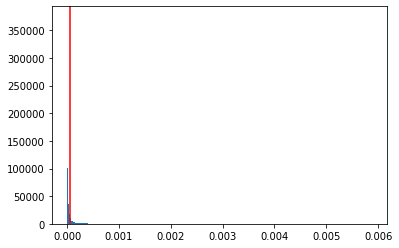

In [110]:
avg_saliency = np.sum(saliency, axis=0) / 146
plt.hist(np.abs(avg_saliency.flatten()), bins=1000)
plt.axvline(np.quantile(np.abs(avg_saliency), 0.8), color="r")

In [49]:
def thresholded_saliency(saliency, threshold):

    _r = saliency.copy()
    th = np.nanquantile(np.abs(_r), threshold)
    _r[np.abs(_r) <= th] = np.nan
    return _r

In [91]:
th_avg[:, 48, :][80:, 20:50]

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

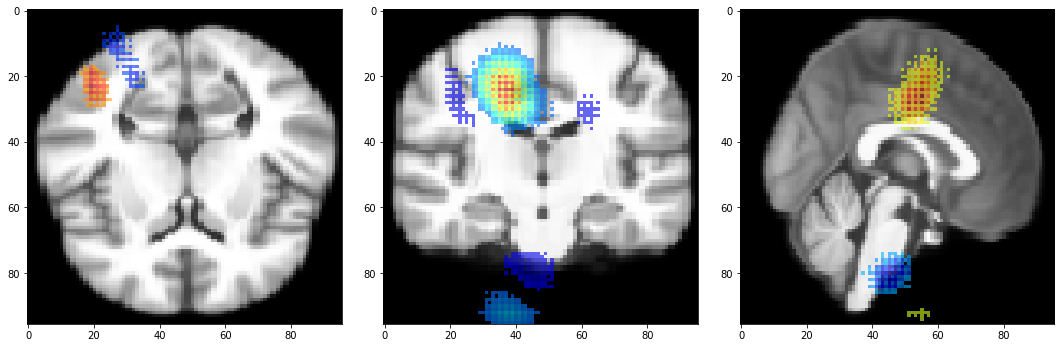

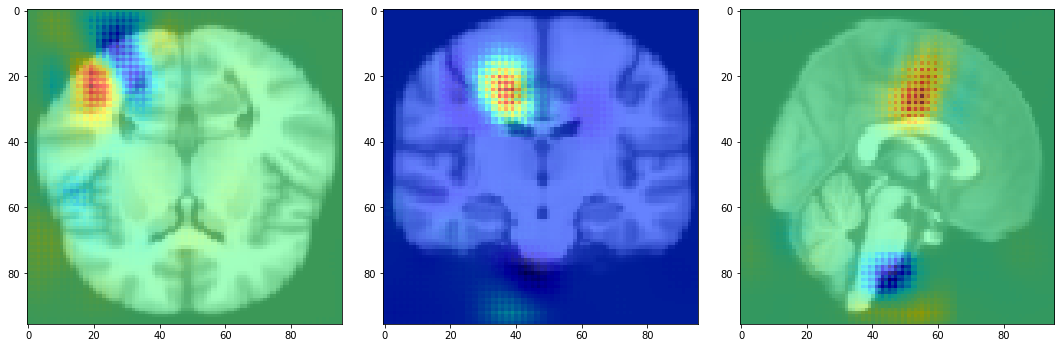

In [88]:
th_avg = thresholded_saliency(avg_saliency, 0.95)
plot_vismap(AVG, th_avg, masked=False)
plot_vismap(AVG, avg_saliency, masked=False);

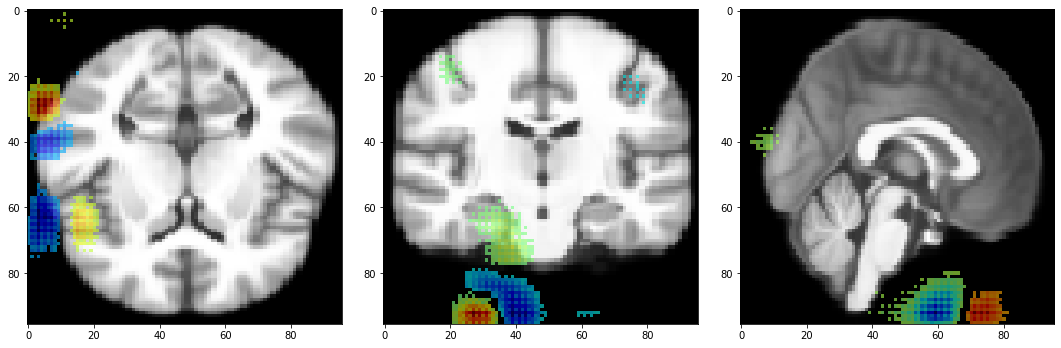

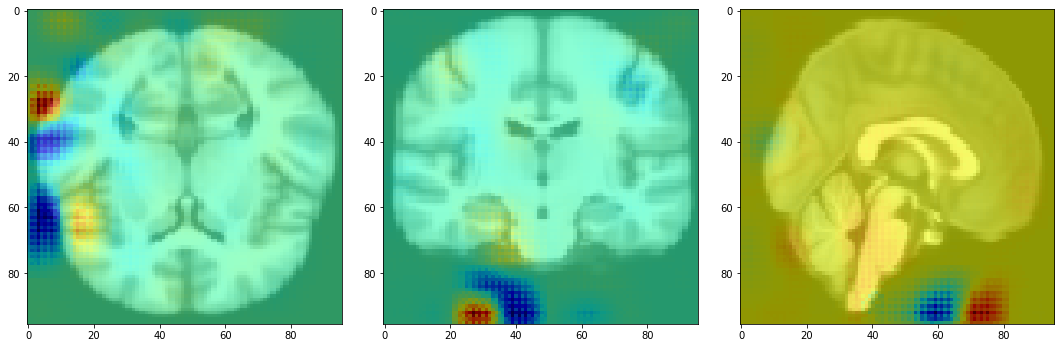

In [95]:
th_avg = thresholded_saliency(avg_saliency, 0.95)
plot_vismap(AVG, th_avg, masked=False)
plot_vismap(AVG, avg_saliency, masked=False);

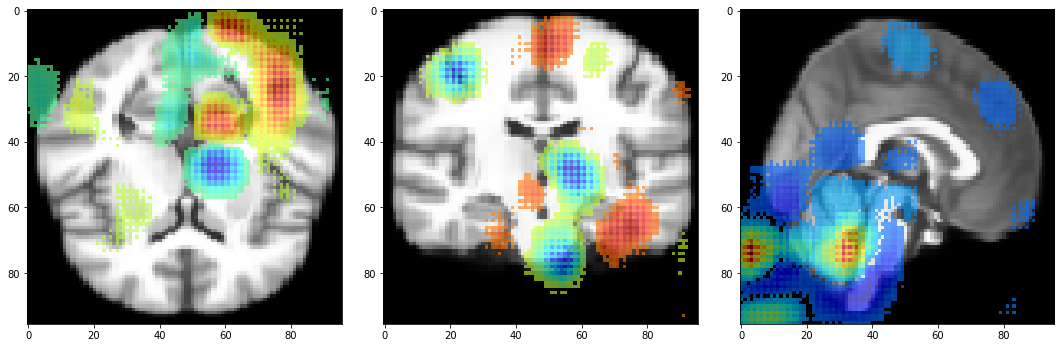

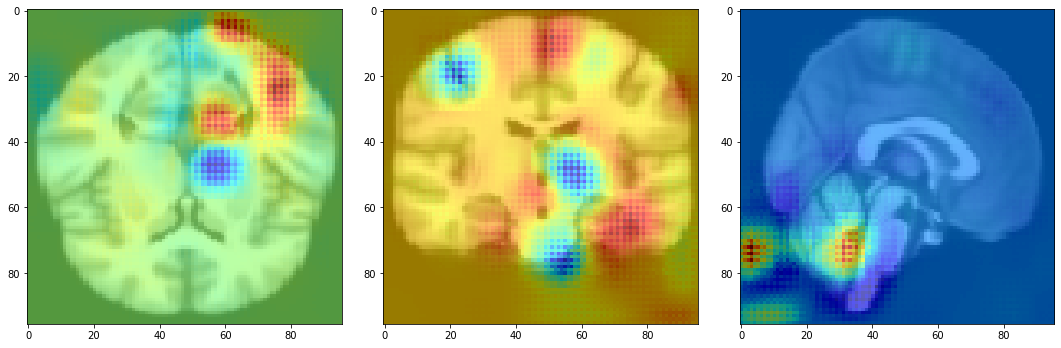

In [111]:
th_avg = thresholded_saliency(avg_saliency, 0.8)
plot_vismap(AVG, th_avg, masked=False)
plot_vismap(AVG, avg_saliency, masked=False);

In [65]:
from captum.attr import DeepLift, GuidedGradCam, GuidedBackprop, Occlusion

In [6]:
x, y, _ = next(iter(trainer.test_dataloader))
x, y = map(lambda x: x.to("cuda"), (x, y))

### Guided Backpropagation

In [53]:
gb = GuidedBackprop(model)

attr = gb.attribute(input)
# attr[attr <= 1e-2] = np.nan

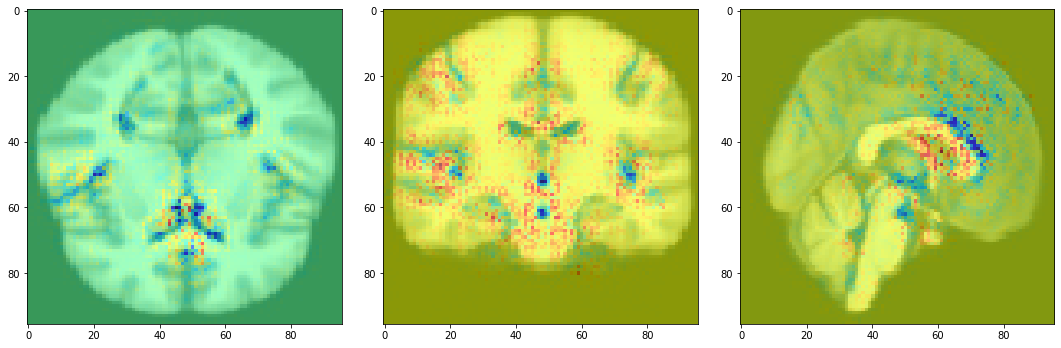

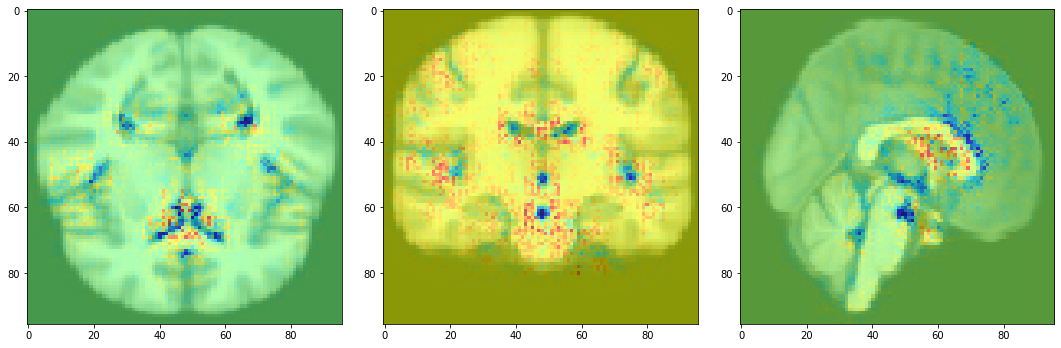

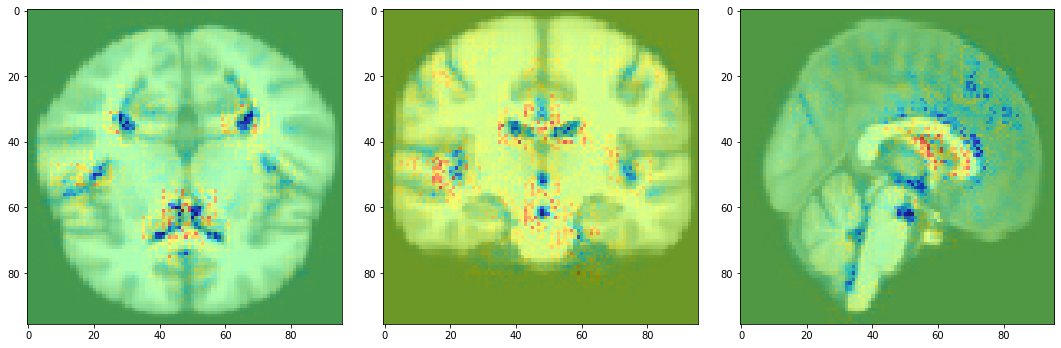

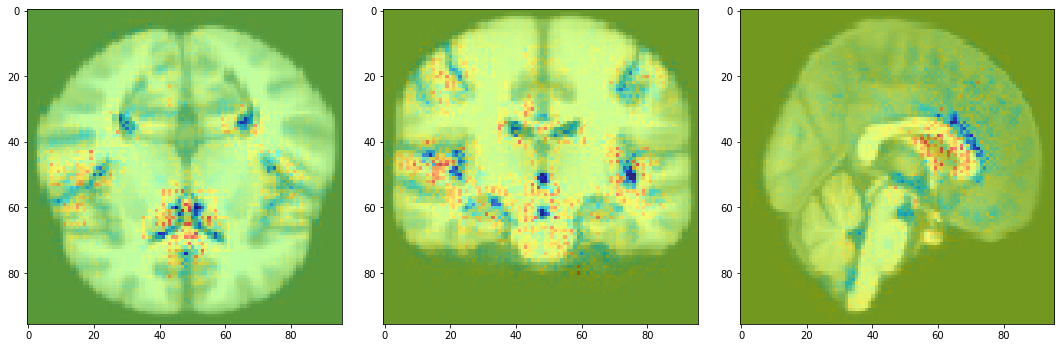

In [54]:
plot_vismap(AVG, attr[0], masked=False)
plot_vismap(AVG, attr[1], masked=False)
plot_vismap(AVG, attr[2], masked=False)
plot_vismap(AVG, attr[3], masked=False);

In [ ]:
saliency = []
for x, y, _ in tqdm(trainer.test_dataloader):

    x, y = map(lambda x: x.to("cuda"), (x, y))
    r = gb.attribute(x)
    saliency.append(r)

saliency = torch.cat(saliency, dim=0).cpu().numpy()

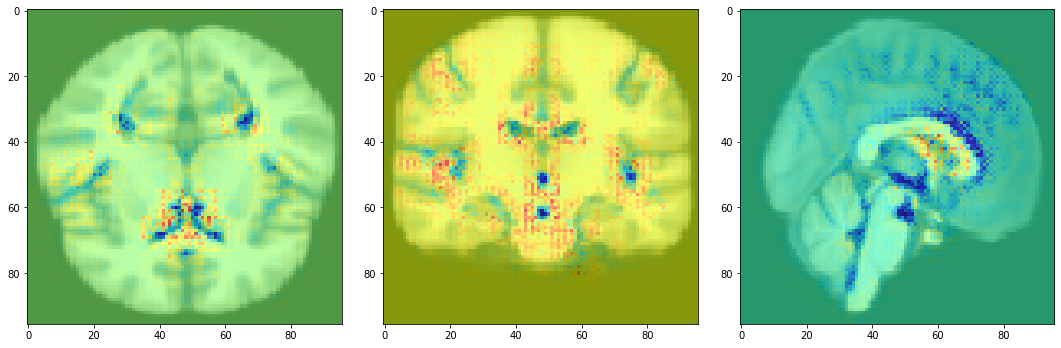

In [59]:
plot_vismap(AVG, saliency.sum(axis=0).squeeze(), masked=False);

### DeepLIFT

In [49]:
dl = DeepLift(model)
attr = dl.attribute(input)
attr[attr <= 1e-6] = np.nan

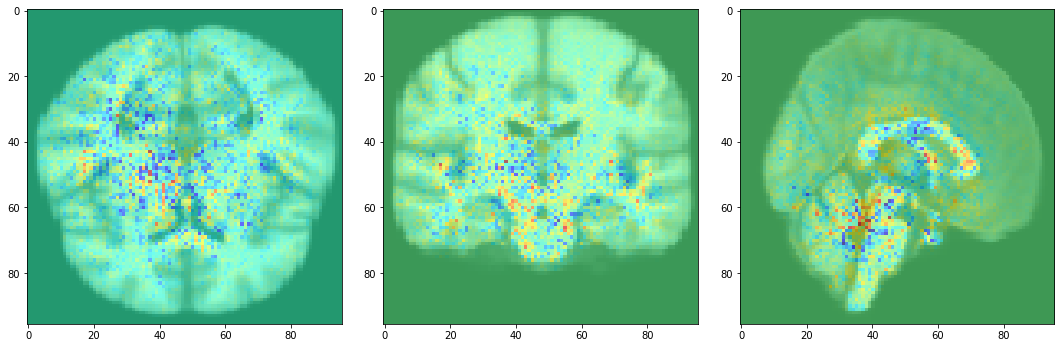

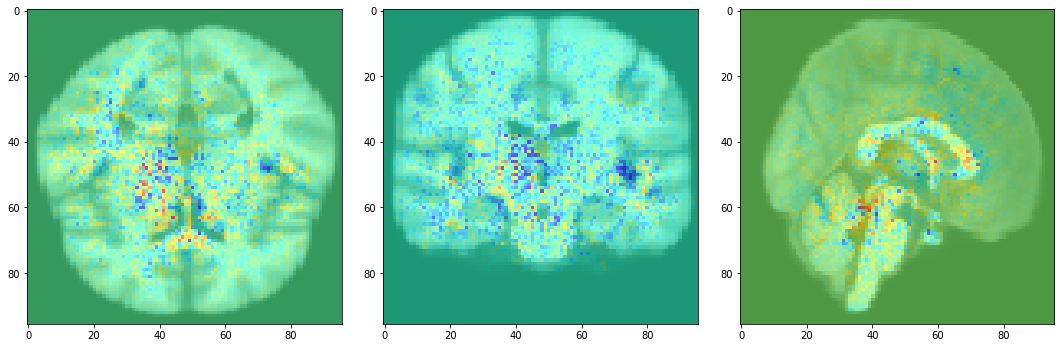

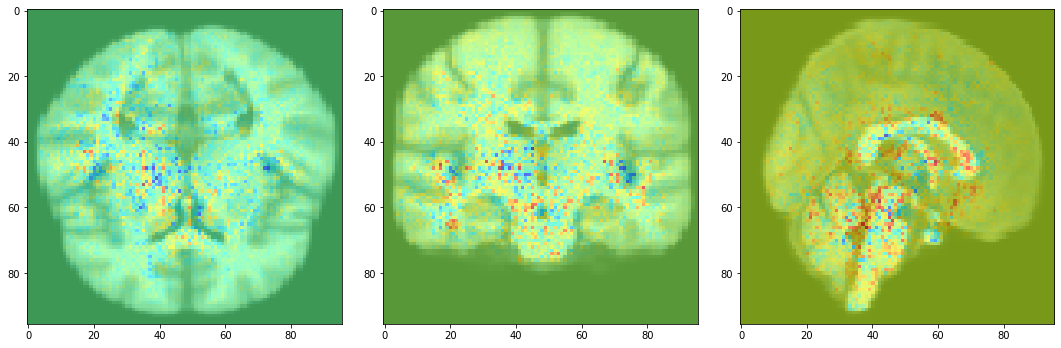

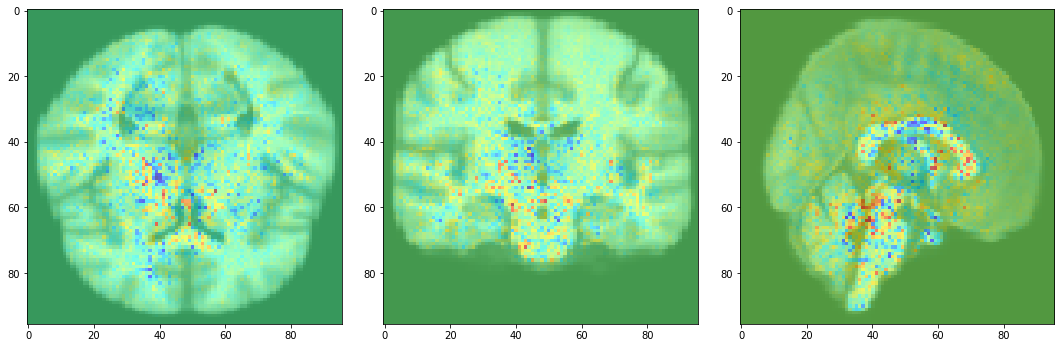

In [50]:
plot_vismap(AVG, attr[0], masked=False)
plot_vismap(AVG, attr[1], masked=False)
plot_vismap(AVG, attr[2], masked=False)
plot_vismap(AVG, attr[3], masked=False);

In [60]:
saliency = []
for x, y, _ in tqdm(trainer.test_dataloader):

    x, y = map(lambda x: x.to("cuda"), (x, y))
    r = dl.attribute(x)
    saliency.append(r)

b
saliency = torch.cat(saliency, dim=0).cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/envs/research/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/opt/conda/envs/research/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/opt/conda/envs/research/lib/python3.8/site-packages/torch/nn/functional.py:847: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool3d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
 10%|█         | 1/10 [00:00<00:02,  3.37it/s]/opt/conda/envs/research/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [62]:
saliency = torch.cat(saliency, dim=0).cpu().detach().numpy()

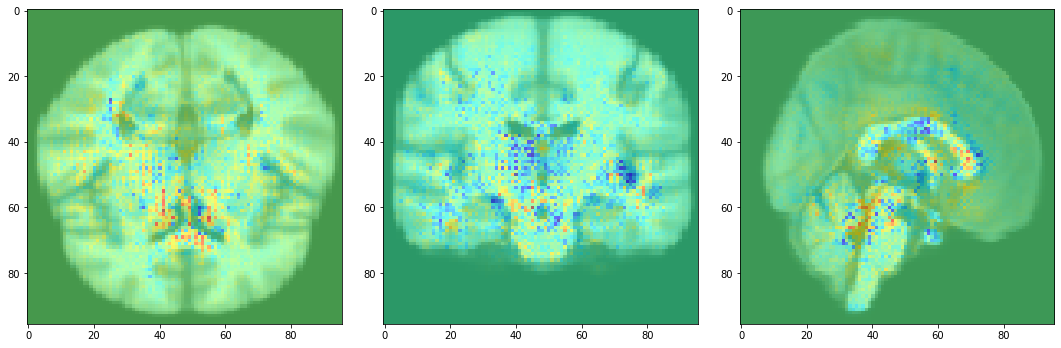

In [63]:
plot_vismap(AVG, saliency.sum(axis=0).squeeze(), masked=False);